# EDA a partir de la API de MELI
### Exploración y análisis
<a id="top"></a>
Autor: Mathiews Flores Zavala

<p> En esta notebook, voy a explorar los resultados de las publicaciones de MELI meduante su API de acceso público. Y se proseguirá a obtener un dataset para trabajar a posteriori, y un análisis exploratorio de los datos</p>

## Tabla de Contenidos
1. <a href="#1">Data Wrangling</a>
* 1.1 <a href="#1.1">Importando librerías y datos</a>
* 1.2 <a href="#1.2">Explorando los datos </a>
* 1.3 <a href="#1.3">Armando el dataset</a>
* 1.4 <a href="#1.4">Analisis del dataset</a>
    * 1.4.1 <a href="#1.4.1">Visualizacion de datos</a>
    * 1.4.2 <a href="#1.4.2">Estudio de correlaciones</a>
    * 1.4.3 <a href="#1.4.3">Respoindiendo algunas preguntas de negocios</a>

2. <a href="#2">Identificado data extra (*Get the Data*)</a>
* 2.1 <a href='#2.1'>Extraccion de datos extra</a>

3. <a href="#3">Conclusion de Parte I</a>
* 3.1 <a href='#3.1'>Preparacion del data set final</a>
* 3.2 <a href='#3.2'>Comentarios finales</a>


---
<a href="#top">Back to Index</a>
<a id="1"></a>
### 1) Data Wrangling
<a id="1.1"></a>
#### 1.1) Importando librerias y datos

In [311]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from time import time, sleep
import re

#from bs4 import BeautifulSoup

Consulto la API de Mercado Libre publica mediante búsquedas. En esta instacia me focalizaré en recopilar datos para componer una muestra de la población de publicaciones disponibles de la API de MELI

In [2]:
url = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k'
result = requests.get(url)
type(result)

requests.models.Response

In [3]:
print('La conexión se logro con exito: ', str(result.status_code == 200))

La conexión se logro con exito:  True


In [4]:
# me fijo en el kas keys de contenido que hay, para darme una idea de lo que puedo obtener y lo que me interesa
data1 = result.json()
data1.keys()

dict_keys(['site_id', 'country_default_time_zone', 'query', 'paging', 'results', 'secondary_results', 'related_results', 'sort', 'available_sorts', 'filters', 'available_filters'])

In [5]:
data1['paging']

{'total': 3434, 'primary_results': 1000, 'offset': 0, 'limit': 50}

In [6]:
print( data1['paging']['total'] )
vector_data1 = list( range(0, data1['paging']['total'] , 50) )

3434


In [7]:
# verificamos la cantidad de registros entregados en la consulta
print('La cantidad de registros por consutla son ',str(len(data1['results'])))

La cantidad de registros por consutla son  50


La busqueda inicial arroja 1000 registros de un total de 3455 de los mismos, donde el límite esta en 50 datos por consulta.
Para no saturar el servicio con las consultas, se explorará inicialmente el contenido del que se dispone, posteriormente se extraera datos para armar un data set orientado hacia elementos digitales (televisores, telefonos, notebooks, tablets)

<a id="1.2"></a>
#### 1.2) Explorando los datos

In [8]:
# explioramos los resultados
data1['results'][1]

{'id': 'MLA905996538',
 'site_id': 'MLA',
 'title': 'Smart Tv Hyundai 50 4k Uhd Google Android ',
 'seller': {'id': 608846165,
  'permalink': 'http://perfil.mercadolibre.com.ar/MERCADOLIBRE+ELECTRONICA_AR',
  'registration_date': '2020-07-13T13:21:30.000-04:00',
  'car_dealer': False,
  'real_estate_agency': False,
  'tags': ['brand',
   'user_info_verified',
   'large_seller',
   'credits_profile',
   'messages_as_seller'],
  'seller_reputation': {'transactions': {'total': 613410,
    'canceled': 28335,
    'period': 'historic',
    'ratings': {'negative': 0.06, 'positive': 0.93, 'neutral': 0.01},
    'completed': 585075},
   'power_seller_status': 'platinum',
   'metrics': {'claims': {'rate': 0.0084, 'value': 1109, 'period': '60 days'},
    'delayed_handling_time': {'rate': 0, 'value': 0, 'period': '60 days'},
    'sales': {'period': '60 days', 'completed': 125242},
    'cancellations': {'rate': 0, 'value': 0, 'period': '60 days'}},
   'level_id': '5_green'}},
 'price': 49999,
 'pric

Observando la documentación, vemos algunas de los atributos de las publicaciones, como el *id* y *título* de cada una de ellas,
informacion del vendedor o *seller* (con su respectivo ID, y sitio en mercado Libre, su fecha de registro, entre otros).
Algunos valores interesantes de esta documentación consiste en la reputación del vendedor, ratings, entre otros.

Otros quizá resuleten no tan informativos, como *prices*, que además de contener algo de iformación redundante como *price, currency* contiene cierta metadata que puede no aportar mucho en una instancia temprana. De esta manera hay otros como *presentation, payment_method_prices*

In [9]:
# hago otra consulta
url = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k&offset=340'
result2 = requests.get(url)
data2 = result2.json()

Se puede obtener hasta 1000 datos sin problemas, que corresponde a los primary_results, posterior a eso necesito el ID_USER para poder acceder a un código para mi url para acceder al resto de los datos. Por ahora voy a dejarlo en 2do plano.
Y realizaré consultas de hasta 1000 registros, siendo conciente que estos 1000 resultados estan inlfuenciados por el propio algoritmo del motor de búsqueda de MELI.

In [10]:
# exploramos los datos del primer dataset
df1 = pd.DataFrame(data1['results'])
df1

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,differential_pricing
0,MLA898264823,MLA,Smart Tv Tcl 50p8m Led 4k 50,"{'id': 185702920, 'permalink': 'http://perfil....",54999.00,"{'id': 'MLA898264823', 'prices': [{'id': '16',...",None,ARS,1,121,...,NaN,MLA1002,NaN,MLA-TELEVISIONS,MLA15186500,"[loyalty_discount_eligible, brand_verified, ex...",True,True,1,NaN
1,MLA905996538,MLA,Smart Tv Hyundai 50 4k Uhd Google Android,"{'id': 608846165, 'permalink': 'http://perfil....",49999.00,"{'id': 'MLA905996538', 'prices': [{'id': '139'...",None,ARS,1,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA17849007,"[extended_warranty_eligible, good_quality_pict...",NaN,True,2,NaN
2,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,"{'id': 608846165, 'permalink': 'http://perfil....",75999.00,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",None,ARS,273,7388,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16233171,"[ahora-12, brand_verified, extended_warranty_e...",True,True,3,{'id': 35713319}
3,MLA933497704,MLA,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,"{'id': 76104882, 'permalink': 'http://perfil.m...",10888.00,"{'id': 'MLA933497704', 'prices': [{'id': '1', ...",None,ARS,3,2,...,NaN,MLA352001,NaN,MLA-STREAMING_MEDIA_DEVICES,MLA14141341,"[good_quality_picture, good_quality_thumbnail,...",True,True,4,NaN
4,MLA926081002,MLA,Smart Tv Bgh 50 Uhd Android,"{'id': 608846165, 'permalink': 'http://perfil....",66999.00,"{'id': 'MLA926081002', 'prices': [{'id': '37',...",None,ARS,250,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,None,"[ahora-12, catalog_product_candidate, extended...",NaN,True,5,{'id': 35713319}
5,MLA884683677,MLA,Smart Tv Samsung 50 4k Uhd 50tu7000,"{'id': 608846165, 'permalink': 'http://perfil....",75999.00,"{'id': 'MLA884683677', 'prices': [{'id': '154'...",None,ARS,250,500,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16233171,"[brand_verified, extended_warranty_eligible, g...",NaN,True,6,{'id': 35713319}
6,MLA929210416,MLA,Smart Tv Philco 50 4k Pld50us21a,"{'id': 608846165, 'permalink': 'http://perfil....",49999.00,"{'id': 'MLA929210416', 'prices': [{'id': '16',...",None,ARS,1,50,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,None,"[extended_warranty_eligible, good_quality_pict...",NaN,True,7,NaN
7,MLA914384399,MLA,Chromecast With Google Tv De Voz 4k 8gb Sno...,"{'id': 82274172, 'permalink': 'http://perfil.m...",11400.00,"{'id': 'MLA914384399', 'prices': [{'id': '18',...",None,ARS,31,180,...,NaN,MLA352001,NaN,MLA-STREAMING_MEDIA_DEVICES,MLA16233185,"[good_quality_picture, good_quality_thumbnail,...",True,True,8,NaN
8,MLA919581387,MLA,Smart Tv Tcl 50p715 Led 4k 50 100v/240v,"{'id': 608846165, 'permalink': 'http://perfil....",65999.00,"{'id': 'MLA919581387', 'prices': [{'id': '132'...",None,ARS,185,865,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16202534,"[ahora-12, extended_warranty_eligible, good_qu...",True,True,9,{'id': 35713319}
9,MLA878666563,MLA,Smart Tv Philips 6600 Series 50pud6654/77 Led ...,"{'id': 608846165, 'permalink': 'http://perfil....",68999.00,"{'id': 'MLA878666563', 'prices': [{'id': '198'...",None,ARS,644,2348,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA15699007,"[ahora-12, brand_verified, extended_warranty_e...",True,True,10,{'id': 35713319}


In [11]:
# conozco las columnas que posee
df1.columns

Index(['id', 'site_id', 'title', 'seller', 'price', 'prices', 'sale_price',
       'currency_id', 'available_quantity', 'sold_quantity', 'buying_mode',
       'listing_type_id', 'stop_time', 'condition', 'permalink', 'thumbnail',
       'thumbnail_id', 'accepts_mercadopago', 'installments', 'address',
       'shipping', 'seller_address', 'attributes', 'original_price',
       'category_id', 'official_store_id', 'domain_id', 'catalog_product_id',
       'tags', 'catalog_listing', 'use_thumbnail_id', 'order_backend',
       'differential_pricing'],
      dtype='object')

Para una instancia a futuro algunos de los campos más interesantes son:
* *installments* > *adress*
* *seller* > *seller_reputation* > *transactions*
* *tag* => se puede aplicar text mining para determinar como inlfuye en las ventas de la publicacion

In [85]:
# suando incluso el código de ID_USER, no se obteiene el resultado esperado
ID_USER = input("Ingrese su ID_USER otorgado por Mercado Libre") 
url = 'https://api.mercadolibre.com/users/$' +str('ID_USER') + '/MLA/search?search_type=scan'
result3 = requests.get(url)
data3 = result3.json()
data3

{'error': 'resource not found',
 'message': 'Si quieres conocer los recursos de la API que se encuentran disponibles visita el Sitio de Desarrolladores de MercadoLibre (http://developers.mercadolibre.com)'}

 <a id="1.3"></a>
#### 1.3) Armando el Dataset
En esta instancia continuaré con el proceso de extracción de datos para armar el dataset

Mediante la definicion de una funcion voy realizar las consultas a la API de MELI cada 15 seg, obteniendo 1000 resultados por busqueda.

En esta instancia, focalizare en ciertos elementos de electronica como tv, celulares, notebooks, tablets (elementos que más destaquen en las búsquedas o con una gran cantidad de publicaciones)

In [22]:
# voy a definir una función para realizar las consultas, y tomar el resultado y entregarlo como un dataset
def call_data(vector = [0,50], url = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k' ):
    '''Funcion para llamar a la API de mercado libre con un resultado especifico, haciendo consultas de 50 en 50
    y guardandolas en un data frame'''
    t = len(vector)
    lista1 = [] #instancio una lista vacia
    for t in list(range( 0,len(vector),1 ) ):
        url_act = url + '&offset=' + str( vector[t] )
        #print(url_act) #para comprobar la direccion
        result = requests.get(url_act)
        if result2.status_code == 200:
            #lista2 = result.json()['results']
            lista1.extend( result.json()['results'] )
        else:
            print('hubo un error')
            df_rta = pd.DataFrame(lista1)  
        print(t, end="\r")
        sleep(15) #cada 15 segundos
        
    df_rta = pd.DataFrame(lista1)    
    return df_rta

In [23]:
df_tv = call_data(
    vector = list( range(0, 1001, 50) ),
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k')

In [24]:
#veamos las dimensiones del data set
df_tv.shape

(1040, 33)

In [25]:
df_tv.to_csv('./data/data_tv_4k_1krows.csv', index= False)

In [26]:
df_tv.head()

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,differential_pricing
0,MLA898264823,MLA,Smart Tv Tcl 50p8m Led 4k 50,"{'id': 185702920, 'permalink': 'http://perfil....",54999.0,"{'id': 'MLA898264823', 'prices': [{'id': '16',...",None,ARS,1,121,...,NaN,MLA1002,NaN,MLA-TELEVISIONS,MLA15186500,"[loyalty_discount_eligible, brand_verified, ex...",True,True,1,NaN
1,MLA905996538,MLA,Smart Tv Hyundai 50 4k Uhd Google Android,"{'id': 608846165, 'permalink': 'http://perfil....",49999.0,"{'id': 'MLA905996538', 'prices': [{'id': '139'...",None,ARS,1,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA17849007,"[extended_warranty_eligible, good_quality_pict...",NaN,True,2,NaN
2,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,"{'id': 608846165, 'permalink': 'http://perfil....",75999.0,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",None,ARS,273,7388,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16233171,"[ahora-12, brand_verified, extended_warranty_e...",True,True,3,{'id': 35713319}
3,MLA933497704,MLA,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,"{'id': 76104882, 'permalink': 'http://perfil.m...",10888.0,"{'id': 'MLA933497704', 'prices': [{'id': '1', ...",None,ARS,3,2,...,NaN,MLA352001,NaN,MLA-STREAMING_MEDIA_DEVICES,MLA14141341,"[good_quality_picture, good_quality_thumbnail,...",True,True,4,NaN
4,MLA926081002,MLA,Smart Tv Bgh 50 Uhd Android,"{'id': 608846165, 'permalink': 'http://perfil....",66999.0,"{'id': 'MLA926081002', 'prices': [{'id': '37',...",None,ARS,250,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,None,"[ahora-12, catalog_product_candidate, extended...",NaN,True,5,{'id': 35713319}


In [28]:
df_cel = call_data(
    vector = list( range(0, 1001, 50) ),
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=celular%20')

#df_cel.to_excel('./data/data_celular_1krows.xlsx', index= False)
df_cel.to_csv('./data/data_celular_1krows.csv', index= False)

In [29]:
df_tab = call_data(
    vector = list( range(0, 1001, 50) ),
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=tablet%20')

df_tab.to_csv('./data/data_tablet_1krows.csv', index= False)

In [30]:
df_notebook = call_data(
    vector = list( range(0, 1001, 50) ),
    url = 'https://api.mercadolibre.com/sites/MLA/search?q=notebook%20')

df_notebook.to_csv('./data/data_notebook_1krows.csv', index= False)

In [ ]:
## solo en el caso de querer leer los archivos desde csv
#df_tv = pd.read_excel('./data/data_tv_4k_1krows.xlsx')
#df_cel = pd.read_excel('./data/data_celular_1krows.xlsx')
#df_notebook = pd.read_excel('./data/data_notebook_1krows.xlsx')
#df_tab = pd.read_excel('./data/data_tablet_1krows.xlsx')

#df_tv = pd.read_csv('./data/data_tv_4k_1krows.csv')
#df_cel = pd.read_csv('./data/data_celular_1krows.csv')
#df_notebook = pd.read_csv('./data/data_notebook_1krows.csv')
#df_tab = pd.read_csv('./data/data_tablet_1krows.csv')

Concatenamos los dataframes obtenidos hasta el momento como uno solo, concatenando uno detras del otro.

In [94]:
# concatenamos los datasets obtenidos hasta el momento
df = pd.concat([df_tv, df_cel, df_tab, df_notebook], axis = 0).reset_index(drop = True)

In [95]:
df

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,differential_pricing
0,MLA898264823,MLA,Smart Tv Tcl 50p8m Led 4k 50,"{'id': 185702920, 'permalink': 'http://perfil....",54999.0,"{'id': 'MLA898264823', 'prices': [{'id': '16',...",None,ARS,1,121,...,NaN,MLA1002,NaN,MLA-TELEVISIONS,MLA15186500,"[loyalty_discount_eligible, brand_verified, ex...",True,True,1,NaN
1,MLA905996538,MLA,Smart Tv Hyundai 50 4k Uhd Google Android,"{'id': 608846165, 'permalink': 'http://perfil....",49999.0,"{'id': 'MLA905996538', 'prices': [{'id': '139'...",None,ARS,1,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA17849007,"[extended_warranty_eligible, good_quality_pict...",NaN,True,2,NaN
2,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,"{'id': 608846165, 'permalink': 'http://perfil....",75999.0,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",None,ARS,273,7388,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,MLA16233171,"[ahora-12, brand_verified, extended_warranty_e...",True,True,3,{'id': 35713319}
3,MLA933497704,MLA,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,"{'id': 76104882, 'permalink': 'http://perfil.m...",10888.0,"{'id': 'MLA933497704', 'prices': [{'id': '1', ...",None,ARS,3,2,...,NaN,MLA352001,NaN,MLA-STREAMING_MEDIA_DEVICES,MLA14141341,"[good_quality_picture, good_quality_thumbnail,...",True,True,4,NaN
4,MLA926081002,MLA,Smart Tv Bgh 50 Uhd Android,"{'id': 608846165, 'permalink': 'http://perfil....",66999.0,"{'id': 'MLA926081002', 'prices': [{'id': '37',...",None,ARS,250,250,...,NaN,MLA1002,1938.0,MLA-TELEVISIONS,None,"[ahora-12, catalog_product_candidate, extended...",NaN,True,5,{'id': 35713319}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,MLA871820328,MLA,Notebook Lenovo V15 Core I5 10ma Gen 1tb + Ssd...,"{'id': 131648529, 'permalink': 'http://perfil....",150985.0,"{'id': 'MLA871820328', 'prices': [{'id': '7', ...",None,ARS,1,5,...,NaN,MLA1652,NaN,MLA-NOTEBOOKS,None,"[brand_verified, extended_warranty_eligible, g...",NaN,False,46,{'id': 35713287}
4156,MLA900496858,MLA,"Notebook Hp 2021 Elite I7 10ma 40gb 17,3 2tb S...","{'id': 141336342, 'permalink': 'http://perfil....",398999.0,"{'id': 'MLA900496858', 'prices': [{'id': '6', ...",None,ARS,5000,5,...,NaN,MLA1652,NaN,MLA-NOTEBOOKS,None,"[loyalty_discount_eligible, brand_verified, go...",NaN,False,47,{'id': 35713287}
4157,MLA895870357,MLA,Notebook Bangho L5 Intel I7-10510u 8gb Ssd240 ...,"{'id': 192106606, 'permalink': 'http://perfil....",159000.0,"{'id': 'MLA895870357', 'prices': [{'id': '5', ...",None,ARS,1,5,...,NaN,MLA1652,NaN,MLA-NOTEBOOKS,MLA17328361,"[good_quality_picture, good_quality_thumbnail,...",NaN,False,48,{'id': 35713231}
4158,MLA866181995,MLA,Notebook Lenovo Ideapad 3 Intel I3 10th 8gb Ss...,"{'id': 82274172, 'permalink': 'http://perfil.m...",83999.0,"{'id': 'MLA866181995', 'prices': [{'id': '17',...",None,ARS,1,50,...,NaN,MLA1652,NaN,MLA-NOTEBOOKS,MLA16053932,"[good_quality_thumbnail, loyalty_discount_elig...",NaN,False,49,NaN


<a id="1.4"></a>
#### 1.4) Analisis del dataset

In [475]:
df.columns

Index(['id', 'site_id', 'title', 'seller', 'price', 'prices', 'sale_price',
       'currency_id', 'available_quantity', 'sold_quantity', 'buying_mode',
       'listing_type_id', 'stop_time', 'condition', 'permalink', 'thumbnail',
       'thumbnail_id', 'accepts_mercadopago', 'installments', 'address',
       'shipping', 'seller_address', 'attributes', 'original_price',
       'category_id', 'official_store_id', 'domain_id', 'catalog_product_id',
       'tags', 'catalog_listing', 'use_thumbnail_id', 'order_backend',
       'differential_pricing'],
      dtype='object')

Al provenir transformar una lista de diccionario, que originalmente venía de una consulta tipo json, me encuentro con que algunas columnas contienen su información en formato dic. Vamos a explorarla, y de paso, ver que información se puede obtener sin tener que aplicar text mining en esta instancia

In [476]:
# exploro la cantidad de nulos y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4160 non-null   object 
 1   site_id               4160 non-null   object 
 2   title                 4160 non-null   object 
 3   seller                4160 non-null   object 
 4   price                 4160 non-null   float64
 5   prices                4160 non-null   object 
 6   sale_price            0 non-null      object 
 7   currency_id           4160 non-null   object 
 8   available_quantity    4160 non-null   int64  
 9   sold_quantity         4160 non-null   int64  
 10  buying_mode           4160 non-null   object 
 11  listing_type_id       4160 non-null   object 
 12  stop_time             4160 non-null   object 
 13  condition             4160 non-null   object 
 14  permalink             4160 non-null   object 
 15  thumbnail            

In [477]:
# 
df.describe()

,price,available_quantity,sold_quantity,original_price,official_store_id,order_backend
count,4.160000e+03,4160.000000,4160.000000,709.000000,621.000000,4160.000000
mean,7.448659e+04,156.363702,50.757212,75526.043554,1090.275362,25.497356
std,3.707253e+05,1515.758183,343.723400,64331.915747,827.029270,14.431171
min,3.300000e+01,1.000000,0.000000,1600.000000,47.000000,1.000000
25%,1.500000e+04,1.000000,1.000000,20899.000000,229.000000,13.000000
50%,4.995850e+04,1.000000,5.000000,59999.000000,1205.000000,25.500000
75%,9.310338e+04,3.000000,25.000000,109999.000000,1938.000000,38.000000
max,2.335000e+07,50000.000000,10459.000000,395999.000000,2588.000000,50.000000


Para este caso, cabe resaltar que *id, order_backend, official_store_id* si bien son numericos no aportan explicaciones al analisis de datos.
En cuanto al resto de las variables, como *price, available_quantity, sold_quantity, original_price* se veran influenciadas por los tipos de productos, y a su vez por las carateristicas del mismo

In [478]:
# tipos de dominios, para identificar si la busqueda me devolvio efectivamente los cambos de las busquedas
df.domain_id.value_counts()

MLA-NOTEBOOKS                                 1050
MLA-TABLETS                                   1040
MLA-CELLPHONES                                1030
MLA-TELEVISIONS                                827
MLA-STREAMING_MEDIA_DEVICES                    110
MLA-TV_REMOTE_CONTROLS                          48
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS         43
MLA-TV_AND_MONITOR_MOUNTS                        9
MLA-TV_REMOTE_CONTROL_COVERS                     1
MLA-TV_RECEIVERS_AND_DECODERS                    1
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS       1
Name: domain_id, dtype: int64

<a id="1.4.1"></a>
#### 1.4.1) Visualizacion de datos

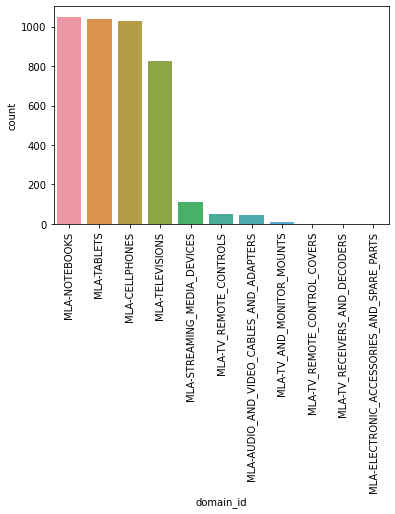

In [479]:
sns.countplot(x='domain_id', data=df,orient = 'v', order=df['domain_id'].value_counts().index)
plt.xticks(rotation=90);
#plt.tight_layout()

In [480]:
(df.groupby('domain_id')['price'].agg(['mean','median','std','max','min']).round(2)).sort_values(by = 'mean', ascending=False)

,mean,median,std,max,min
domain_id,,,,,
MLA-NOTEBOOKS,116546.39,107387.00,54240.77,469999.0,1000.00
MLA-TELEVISIONS,113612.55,76373.00,137005.58,1998000.0,33.00
MLA-TABLETS,53702.18,15998.50,724472.94,23350000.0,65.00
MLA-CELLPHONES,35290.52,23749.00,38514.98,389990.0,50.00
MLA-STREAMING_MEDIA_DEVICES,10610.85,10199.50,4871.46,49400.0,5259.00
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS,6999.00,6999.00,NaN,6999.0,6999.00
MLA-TV_RECEIVERS_AND_DECODERS,5869.00,5869.00,NaN,5869.0,5869.00
MLA-TV_AND_MONITOR_MOUNTS,2335.72,499.99,3344.27,9380.0,299.99
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,1544.69,1299.00,1151.53,3990.0,199.91


Las notebooks representan aquellos productos que tienen el mayor precio promedio (independientemente de la gama del articulo)
En tanto que los celulares tienen el menor precio medio.
La diferencia entre la media y la mediana en estos casos se debe, ademas de la presencia de outliers en los datos, dependera de las carateristicas y la cantidad de productos para las distintas gamas.

Tambien podemos ver que los maximos hay valores hasta 2 ordenedes de magnitud por encima del orden de la media y la mediana. En el caso de Tablets por ejemplo, la media y mediana estan en el orden de 1e4, en tanto que el maximo valor esta en el orden de 1e7; otro sucede con los televisores.


Aquellos que tienen std = NaN, son aquellos elementos que son unicos, ya que temino dividinedo por 0 (n-1).
Estos son productos que se colaron el la busqueda de television, donde los resultados entregados no fueron tan precisos como con tablets, notebooks y celulares.

domain_id = ['MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS', 'MLA-TV_RECEIVERS_AND_DECODERS', 'MLA-TV_REMOTE_CONTROL_COVERS']



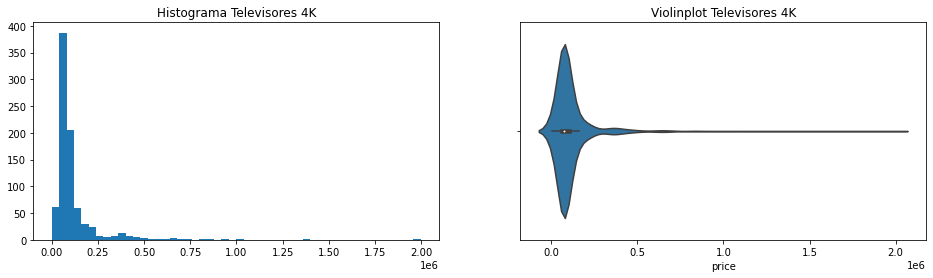

In [481]:
plt.figure(figsize = (16, 4))

ax = plt.subplot(1,2,1)
data_2plot = df[df['domain_id'] == 'MLA-TELEVISIONS']
plt.hist(data=data_2plot, x='price', bins=50)
plt.title('Histograma Televisores 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10)
plt.title('Violinplot Televisores 4K')
plt.show()

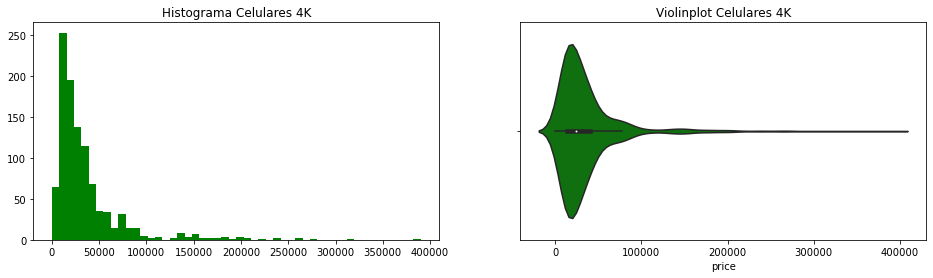

In [482]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = df[df['domain_id'] == 'MLA-CELLPHONES']
plt.hist(data=data_2plot, x='price', bins=50, color= 'green')
plt.title('Histograma Celulares 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10, color= 'green')
plt.title('Violinplot Celulares 4K')
plt.show()

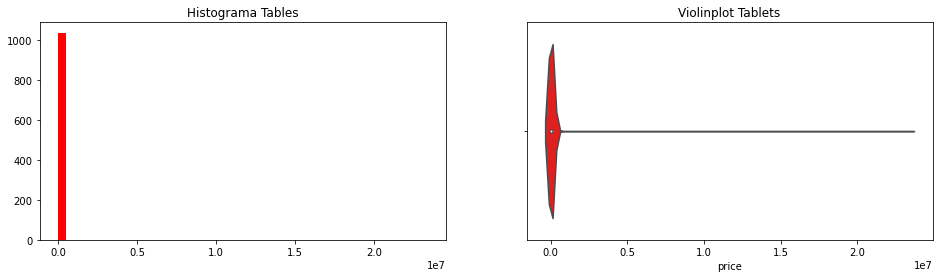

In [483]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = df[df['domain_id'] == 'MLA-TABLETS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Histograma Tables')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Violinplot Tablets')
plt.show()

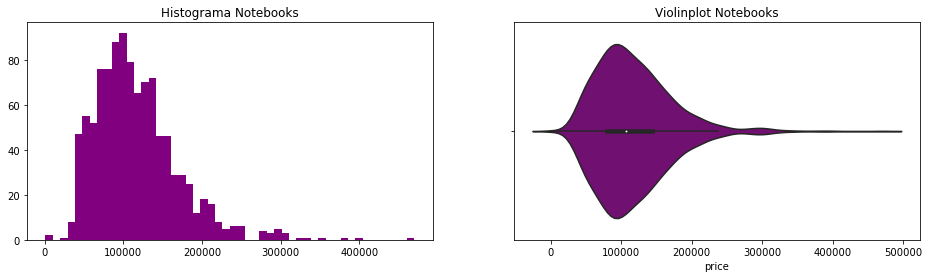

In [548]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = df[df['domain_id'] == 'MLA-NOTEBOOKS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Histograma Notebooks')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Violinplot Notebooks')
plt.show()

In [485]:
(df.groupby('domain_id')['sold_quantity'].agg(['mean','median','std','max','min']).round(2)).\
                        sort_values(by = 'mean', ascending=False)

,mean,median,std,max,min
domain_id,,,,,
MLA-STREAMING_MEDIA_DEVICES,94.85,50.0,134.57,623,1
MLA-CELLPHONES,91.97,5.0,537.62,10459,0
MLA-TV_REMOTE_CONTROLS,89.56,37.5,137.68,500,4
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,65.19,5.0,105.82,500,2
MLA-TV_AND_MONITOR_MOUNTS,62.44,25.0,83.82,250,3
MLA-TV_REMOTE_CONTROL_COVERS,50.00,50.0,NaN,50,50
MLA-TABLETS,45.17,2.0,332.77,9924,0
MLA-NOTEBOOKS,29.32,5.0,74.09,706,0
MLA-TELEVISIONS,24.79,0.0,284.00,7388,0


En cuanto a las unidades vendidas por categorías se puede apreciar que la media ronda el mismo orden para los distintos productos.
Sin embargo puede llegar a ser muy dispar las ventas que se producen para las distintas publicaciones y vendedores, nos podemos dar cuenta de ello debido a las medianas cuando son muy pequeñas respecto de su media, y el maximo es bastante mayor.

<a id="1.4.2"></a>
#### 1.4.2) Estudio de correlaciones

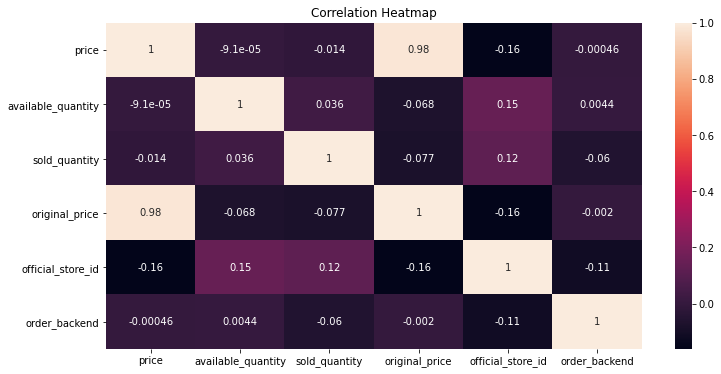

In [486]:
# graficamos un heatmap para exploras la relacion entre variables
plt.figure(figsize=(12,6))
# para no incorporar solamente aquellas variables numericas, ya que de lo contrario me tomaria los buleanos 
num_cols = [x for x in df.select_dtypes(include=['number']).columns]
sns.heatmap(df[num_cols].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

De los valores numericos, ignorando *id, order_backend, official_store_id* hay una fuerte corelacion entre price y original_price, y no es 1 directamente debido a que existen descuento aplicado, de lo contrario seria null en este caso.

<a id="1.4.3"></a>
#### 1.4.3) Respoindiendo algunas preguntas de negocios
Veamos cuantos productos tienen descuentos en esta muestra:

In [487]:
(df.original_price.isnull()).value_counts()

True     3451
False     709
Name: original_price, dtype: int64

In [488]:
# cuantos productos generales tienen descuento, y que % representa del total
print("La cantidad de productos con descuento es {}, y representa el {} % del total de productos de las busquedas".format(
        (df.original_price.isnull()).value_counts()[0] ,
        round(((df.original_price.isnull()).value_counts()[0] / len(df))*100, 2)
        )
     )

La cantidad de productos con descuento es 709, y representa el 17.04 % del total de productos de las busquedas


In [489]:
categoria_productos = {'televisores':'MLA-TELEVISIONS','celulares':'MLA-CELLPHONES','tablets':'MLA-TABLETS',\
                       'notebooks':'MLA-NOTEBOOKS'}
descuentos_productos = pd.DataFrame(categoria_productos, index = ['domain_id']).T
for key in categoria_productos:
    #auxi = re.sub('MLA-', '', domain)
    cant_prod_cdescuento = (df[df['domain_id'] == categoria_productos[key] ].original_price.isnull()).value_counts()[0]
    cant_prod_categoria = len(df[df['domain_id'] == categoria_productos[key] ])
    print("La cantidad de ", str(key) ," con descuento es {}, de un total de {} y representa el {} %".format(
            cant_prod_cdescuento,
            cant_prod_categoria,
            round((cant_prod_cdescuento /cant_prod_categoria )*100,2)
            )
         )
    #asignacion de cantidad de descuentos
    descuentos_productos.loc[key,'ratio_prod_wdiscount'] = (cant_prod_cdescuento /cant_prod_categoria )
    

La cantidad de  televisores  con descuento es 99, de un total de 827 y representa el 11.97 %
La cantidad de  celulares  con descuento es 146, de un total de 1030 y representa el 14.17 %
La cantidad de  tablets  con descuento es 172, de un total de 1040 y representa el 16.54 %
La cantidad de  notebooks  con descuento es 270, de un total de 1050 y representa el 25.71 %


Los productos con mayor cantidad de descuentos son las notebooks, en tanto que los que tienen menor ratio de descuentos son los televisores, basado en nuestra muestra.

In [490]:
# veamos como nos va con los descuentos
comparacion_descuentos = df[df['original_price'].notnull()][['price','original_price','domain_id']].copy()
# verifico que todos los datos sean fiables, debe coincidir con la cantidad de descuentos.
print('Cantidad de valores con descuento :',
      str( (comparacion_descuentos.original_price > comparacion_descuentos.price).sum() ))
print('Cantidad de valores sin descuento:',
      str( (comparacion_descuentos.original_price == comparacion_descuentos.price).sum() ))

Cantidad de valores con descuento : 704
Cantidad de valores sin descuento: 5


Algo que podemos notar es que no deberian figurar valores donde *original_price == price*, ya que es una condicion de este dataset. En estos casos pudo haber siso un error durante la carga.

In [491]:
# Para conocer el promedio de descuestos necesito solamente considerar aquellos que realmente tienen descuento
comparacion_descuentos = comparacion_descuentos[\
                        comparacion_descuentos['original_price']>comparacion_descuentos['price']]
# calculo el descuento general independientemente de la categoria
print('El porcentaje de descuento promedio para los productos en oferta(con descuentos) es de {}%'.format(\
    round(( (comparacion_descuentos.original_price.sum()-comparacion_descuentos.price.sum())/\
    comparacion_descuentos.original_price.sum())*100, 2) ))
# calculo el descuento para las categorias de interes
for key in categoria_productos:
    descuento = (comparacion_descuentos[comparacion_descuentos['domain_id']==categoria_productos[key]].original_price.sum()-\
                 comparacion_descuentos[comparacion_descuentos['domain_id']==categoria_productos[key]].price.sum() )/\
                 comparacion_descuentos[comparacion_descuentos['domain_id']==categoria_productos[key]].original_price.sum()
    print('El porcentaje de descuento promedio de la categoria ', str(key) ,' es de {}%'.format(
            round(descuento*100,2)
            )
         )
    #asignacion de cantidad de descuentos
    descuentos_productos.loc[key,'prom_discount'] = descuento

El porcentaje de descuento promedio para los productos en oferta(con descuentos) es de 15.24%
El porcentaje de descuento promedio de la categoria  televisores  es de 12.88%
El porcentaje de descuento promedio de la categoria  celulares  es de 13.45%
El porcentaje de descuento promedio de la categoria  tablets  es de 20.14%
El porcentaje de descuento promedio de la categoria  notebooks  es de 15.58%


In [492]:
descuentos_productos

,domain_id,ratio_prod_wdiscount,prom_discount
televisores,MLA-TELEVISIONS,0.119710,0.128813
celulares,MLA-CELLPHONES,0.141748,0.134494
tablets,MLA-TABLETS,0.165385,0.201432
notebooks,MLA-NOTEBOOKS,0.257143,0.155849


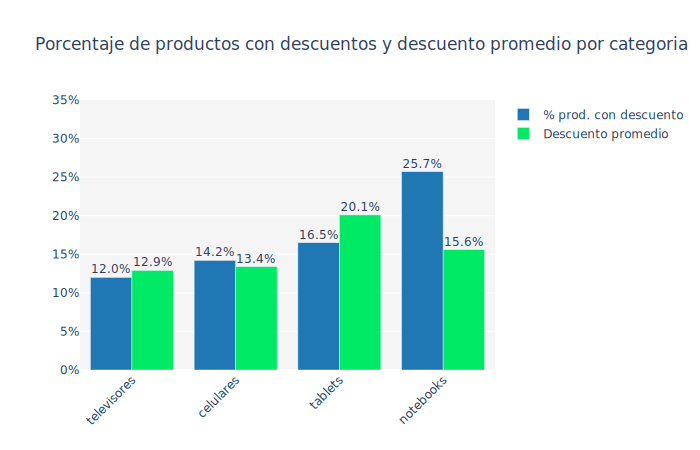

In [493]:
x_2plot = np.array(descuentos_productos.index)
y_2plot1 = np.array(descuentos_productos.iloc[:,1].apply(lambda x: round(x,3)))
y_2plot2 = np.array(descuentos_productos.iloc[:,2].apply(lambda x: round(x,3)))

xcoord4 = range(0,4)
xi = range(len(xcoord4))
yi = range

annotations1 = [dict(x=xi-0.2,y=yi ,text=str(yi*100)+'%',xanchor='auto',yanchor='bottom',showarrow=False,
                    ) for xi, yi in zip(xcoord4, y_2plot1)]

annotations2 = [dict(x=xi+0.2,y=yi ,text=str(yi*100)+'%',xanchor='auto',yanchor='bottom',showarrow=False,
                    ) for xi, yi in zip(xcoord4, y_2plot2)]

annotations = annotations1 + annotations2

trace1 = go.Bar(x=x_2plot, y=y_2plot1, textposition='auto', name='% prod. con descuento', marker_color='#1f77b4',)
trace2 = go.Bar(x=x_2plot, y=y_2plot2, textposition='auto', name='Descuento promedio', marker_color='#00EA65')

data = [trace1, trace2]
layout = go.Layout(barmode='group',annotations=annotations, xaxis_tickangle=-45)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(title='Porcentaje de productos con descuentos y descuento promedio por categoria'\
                  ,plot_bgcolor= 'whitesmoke',autosize=True)
fig.update_yaxes(tickformat=',.0%',range=[0.0,0.35], constrain="domain")
fig.show('svg')

Continuando con el analisis del data set, encontramos que una manera de manejar los nulos de *original_price* es reemplazarlos por el valor original, y si bien esta columna a futuro podria no servinos debido a su fuerte correlacion con *price*, servira para determinar el descuento aplicado sobre el producto, si lo hay.

In [535]:
categoria_productos[key]

'MLA-NOTEBOOKS'

In [546]:
# veamos la cantidad de productos usados que hay
print('La cantidad de productos usados en las publicaciones es de {}, que respresenta el {}% de las publicaciones'.format(
    len(df[df['condition']=='used']), round(len(df[df['condition']=='used'])/len(df), 2)*100 ))

for key in categoria_productos:
    cant_prod_usados = len(df[(df['condition']=='used') & (df['domain_id'] == categoria_productos[key])])
    cant_prod_categoria = len(df[df['domain_id'] == categoria_productos[key] ])
    print("La cantidad de ", str(key) ," usados es de {}, de un total de {} y representa el {} %".format(
            cant_prod_usados,
            cant_prod_categoria,
            round((cant_prod_usados /cant_prod_categoria )*100,2)
            )
         )
    #asignacion de cantidad de descuentos
    #descuentos_productos.loc[key,'productos nuevos'] = (cant_prod_cdescuento /cant_prod_categoria )

La cantidad de productos usados en las publicaciones es de 262, que respresenta el 6.0% de las publicaciones
La cantidad de  televisores  usados es de 73, de un total de 827 y representa el 8.83 %
La cantidad de  celulares  usados es de 40, de un total de 1030 y representa el 3.88 %
La cantidad de  tablets  usados es de 148, de un total de 1040 y representa el 14.23 %
La cantidad de  notebooks  usados es de 1, de un total de 1050 y representa el 0.1 %


Es interesante observar que la mayor parte de los productos son nuevos, en un 94%.
De los cuales las tables son los productos que tienen mayor porcentaje de productos usados.

<a href="#top">Back to Index</a>
<a id="2"></a>
### 2) Identificado data extra (*Get the Data*)
<a id="2.1"></a>
#### 2.1) Extraccion de datos extra

El data set obtenido de los *results* de la consulta existen ciertos campos referidos tanto al proveedor, su historia y rating, entre otros, que son diccionarios contenidos en una columna del dataframe. Se identificarán las mismas, y mediante una función “expandiremos” dicho data set. Esto en medida que los valores sean significativos al modelo de negocio, en función de mi propio entendimiento.

In [494]:
# quiero explorar el contenido del diccionario que contienen algunas columnas
pd.DataFrame(list(df.seller)).sample(5)

,id,permalink,registration_date,car_dealer,real_estate_agency,tags,eshop,seller_reputation
1568,179274188,http://perfil.mercadolibre.com.ar/DALECL%C3%8DCK,2015-03-16T08:07:23.000-04:00,False,False,"[normal, user_info_verified, credits_profile, ...","{'nick_name': 'DALECLÍCK', 'eshop_rubro': None...","{'transactions': {'total': 129585, 'canceled':..."
290,211081461,http://perfil.mercadolibre.com.ar/LCPI,2016-04-12T15:21:24.000-04:00,False,False,"[normal, user_info_verified, credits_profile, ...","{'nick_name': 'LCPI', 'eshop_rubro': None, 'es...","{'transactions': {'total': 10214, 'canceled': ..."
1999,119914491,http://perfil.mercadolibre.com.ar/GAMESTATION+ARG,2012-08-22T11:06:10.000-04:00,False,False,"[normal, user_info_verified, medium_seller, es...","{'nick_name': 'GAMESTATION ARG', 'eshop_rubro'...","{'transactions': {'total': 21363, 'canceled': ..."
2552,284824585,http://perfil.mercadolibre.com.ar/SKY-+VISION,2017-11-17T09:42:03.000-04:00,False,False,"[normal, user_info_verified, credits_profile, ...","{'nick_name': 'SKY.VISION ELECTRONICA', 'eshop...","{'transactions': {'total': 17534, 'canceled': ..."
1084,179579764,http://perfil.mercadolibre.com.ar/NALDO+LOMBARDI,2015-03-20T11:28:24.000-04:00,False,False,"[brand, user_info_verified, large_seller, msho...",NaN,"{'transactions': {'total': 20541, 'canceled': ..."


In [495]:
def extrac_new_DF_from_colum(df_2work, column_2work, option =1):
    '''Debido a la naturaleza de extraccion de datos de las APIs para evitar colapsar el servicio, en oportunidades
    hay diccionarios en alguna de las columnas al tratarse de archivos tipo json()
    con esta funcion indicamos el DF, y la columna de interes para devolver un nuevo dataframe
    df_2work => DataFrame de pandas
    colum_2work => 'string
    option = 1 o 2 devuelve un dataframe con y sin el atributo column_2work en el dataframe'''
    if option == 1:
        return pd.DataFrame( list(df_2work[column_2work]) ) #para probar, pero sin dropear la columna
    elif option == 2:
        # alternativa para expandir el dataframe en aquellas columnas que se duplican, me ahorro de pasos
        # con pop extraigola columna de interes para no dropear en otro paso
        return pd.concat([df_2work.drop([column_2work], axis=1), df_2work[column_2work].apply(pd.Series)], axis=1)


In [496]:
df = extrac_new_DF_from_colum(df, 'seller', 2)

Uno de los topicos interesantes es la reputacion del vendedor, *seller_reputation* 

In [497]:
df2 = extrac_new_DF_from_colum(df, 'seller_reputation', 1)

In [498]:
df2

,transactions,power_seller_status,metrics,level_id,protection_end_date,real_level
0,"{'total': 74089, 'canceled': 4248, 'period': '...",platinum,"{'claims': {'rate': 0.0148, 'value': 185, 'per...",5_green,NaN,NaN
1,"{'total': 613410, 'canceled': 28335, 'period':...",platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN
2,"{'total': 613410, 'canceled': 28335, 'period':...",platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN
3,"{'total': 15765, 'canceled': 605, 'period': 'h...",platinum,"{'claims': {'rate': 0, 'value': 1, 'period': '...",5_green,NaN,NaN
4,"{'total': 613410, 'canceled': 28335, 'period':...",platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN
...,...,...,...,...,...,...
4155,"{'total': 24796, 'canceled': 1047, 'period': '...",platinum,"{'claims': {'rate': 0.0153, 'value': 49, 'peri...",5_green,NaN,NaN
4156,"{'total': 1229, 'canceled': 51, 'period': 'his...",gold,"{'claims': {'rate': 0, 'value': 1, 'period': '...",5_green,NaN,NaN
4157,"{'total': 776, 'canceled': 29, 'period': 'hist...",gold,"{'claims': {'rate': 0, 'value': 0, 'period': '...",5_green,NaN,NaN
4158,"{'total': 27138, 'canceled': 995, 'period': 'h...",platinum,"{'claims': {'rate': 0.0088, 'value': 30, 'peri...",5_green,NaN,NaN


In [499]:
df2 = extrac_new_DF_from_colum(df2, 'transactions', 2)

In [500]:
df2.head()

,power_seller_status,metrics,level_id,protection_end_date,real_level,total,canceled,period,ratings,completed
0,platinum,"{'claims': {'rate': 0.0148, 'value': 185, 'per...",5_green,NaN,NaN,74089,4248,historic,"{'negative': 0.02, 'positive': 0.96, 'neutral'...",69841
1,platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN,613410,28335,historic,"{'negative': 0.06, 'positive': 0.93, 'neutral'...",585075
2,platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN,613410,28335,historic,"{'negative': 0.06, 'positive': 0.93, 'neutral'...",585075
3,platinum,"{'claims': {'rate': 0, 'value': 1, 'period': '...",5_green,NaN,NaN,15765,605,historic,"{'negative': 0, 'positive': 0.99, 'neutral': 0...",15160
4,platinum,"{'claims': {'rate': 0.0084, 'value': 1109, 'pe...",5_green,NaN,NaN,613410,28335,historic,"{'negative': 0.06, 'positive': 0.93, 'neutral'...",585075


In [501]:
df2 = extrac_new_DF_from_colum(df2, 'ratings', 2)
df2 = extrac_new_DF_from_colum(df2, 'metrics', 2)

In [502]:
df2.sample(5)

,power_seller_status,level_id,protection_end_date,real_level,total,canceled,period,completed,negative,positive,neutral,claims,delayed_handling_time,sales,cancellations
3197,platinum,5_green,NaN,NaN,58396,2731,historic,55665,0.01,0.99,0.00,"{'rate': 0.0079, 'value': 93, 'period': '60 da...","{'rate': 0, 'value': 1, 'period': '60 days'}","{'period': '60 days', 'completed': 11117}","{'rate': 0.0069, 'value': 81, 'period': '60 da..."
3412,platinum,5_green,NaN,NaN,17912,798,historic,17114,0.01,0.98,0.01,"{'rate': 0.0064, 'value': 19, 'period': '60 da...","{'rate': 0.0105, 'value': 29, 'period': '60 da...","{'period': '60 days', 'completed': 2820}","{'rate': 0.0013, 'value': 4, 'period': '60 days'}"
1657,platinum,5_green,2021-08-25T00:00:00.000-04:00,yellow,27839,2625,historic,25214,0.05,0.93,0.02,"{'rate': 0, 'excluded': {'real_rate': 0.0202, ...","{'rate': 0, 'excluded': {'real_rate': 0.0004, ...","{'period': '60 days', 'completed': 2370}","{'rate': 0, 'excluded': {'real_rate': 0.0015, ..."
3418,platinum,5_green,NaN,NaN,6011,284,historic,5727,0.01,0.98,0.01,"{'rate': 0.0114, 'value': 12, 'period': '60 da...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 1003}","{'rate': 0.0047, 'value': 5, 'period': '60 days'}"
4058,gold,5_green,NaN,NaN,4278,169,historic,4109,0.02,0.98,0.00,"{'rate': 0, 'value': 1, 'period': '60 days'}","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 451}","{'rate': 0, 'value': 0, 'period': '60 days'}"


In [503]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   power_seller_status    3561 non-null   object 
 1   level_id               4073 non-null   object 
 2   protection_end_date    429 non-null    object 
 3   real_level             429 non-null    object 
 4   total                  4160 non-null   int64  
 5   canceled               4160 non-null   int64  
 6   period                 4160 non-null   object 
 7   completed              4160 non-null   int64  
 8   negative               4160 non-null   float64
 9   positive               4160 non-null   float64
 10  neutral                4160 non-null   float64
 11  claims                 4160 non-null   object 
 12  delayed_handling_time  4160 non-null   object 
 13  sales                  4160 non-null   object 
 14  cancellations          4160 non-null   object 
dtypes: f

En esta instancia se han obtenido datos interesantes como la cantidad de ventas concretadas *completed*, las ventas canceladas *canceled* y el totas de los pedidos (la suma de las anteriores)

Además, del rate que es un porcentual y puede ser *negative, positive* o *neutral*.

Como en ningun momento he dropeado valores, eliminado registros, o más alla del *reset_index* aplicado en la generacion del dataframe de partida df, puedo mergear el data set *df* con *df2*. Por el momento seguire explorando el dataset

In [504]:
extrac_new_DF_from_colum(df, 'address', 1)

,state_id,state_name,city_id,city_name
0,AR-C,Capital Federal,None,Once
1,AR-B,Buenos Aires,None,Villa Celina
2,AR-B,Buenos Aires,None,Villa Celina
3,AR-C,Capital Federal,None,CABA
4,AR-B,Buenos Aires,None,Villa Celina
...,...,...,...,...
4155,AR-C,Capital Federal,TUxBQlZJTDQyMjBa,Villa Crespo
4156,AR-C,Capital Federal,TUxBQkJFTDcyNTJa,Belgrano
4157,AR-B,Buenos Aires,None,Villa Bosch
4158,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás


Incluso hay otra columna con atributos similares

In [505]:
extrac_new_DF_from_colum(df, 'seller_address', 1)

,id,comment,address_line,zip_code,country,state,city,latitude,longitude
0,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-C', 'name': 'Capital Federal'}","{'id': None, 'name': 'Once'}",,
1,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-B', 'name': 'Buenos Aires'}","{'id': None, 'name': 'Villa Celina'}",,
2,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-B', 'name': 'Buenos Aires'}","{'id': None, 'name': 'Villa Celina'}",,
3,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-C', 'name': 'Capital Federal'}","{'id': None, 'name': 'CABA'}",,
4,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-B', 'name': 'Buenos Aires'}","{'id': None, 'name': 'Villa Celina'}",,
...,...,...,...,...,...,...,...,...,...
4155,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-C', 'name': 'Capital Federal'}","{'id': 'TUxBQlZJTDQyMjBa', 'name': 'Villa Cres...",,
4156,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-C', 'name': 'Capital Federal'}","{'id': 'TUxBQkJFTDcyNTJa', 'name': 'Belgrano'}",,
4157,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-B', 'name': 'Buenos Aires'}","{'id': None, 'name': 'Villa Bosch'}",,
4158,,,,,"{'id': 'AR', 'name': 'Argentina'}","{'id': 'AR-C', 'name': 'Capital Federal'}","{'id': 'TUxBQlNBTjgzMjRa', 'name': 'San Nicolás'}",,


Como se puede apreciar *seller_address* tiene contenido redundante comparado con *address* por lo tanto solo expandire el data set original *df* para address.
Se puede rescatar de la misma *state_name, city_name* ya que el resto del contenido sera redundante, o no aporta valor agregado.

In [506]:
df = extrac_new_DF_from_colum(df, 'address', 2)

In [507]:
# exploremos un poco el contenido del origen de las publicaciones
localizaciones = df[['state_name','city_name','domain_id']].copy()
localizaciones

,state_name,city_name,domain_id
0,Capital Federal,Once,MLA-TELEVISIONS
1,Buenos Aires,Villa Celina,MLA-TELEVISIONS
2,Buenos Aires,Villa Celina,MLA-TELEVISIONS
3,Capital Federal,CABA,MLA-STREAMING_MEDIA_DEVICES
4,Buenos Aires,Villa Celina,MLA-TELEVISIONS
...,...,...,...
4155,Capital Federal,Villa Crespo,MLA-NOTEBOOKS
4156,Capital Federal,Belgrano,MLA-NOTEBOOKS
4157,Buenos Aires,Villa Bosch,MLA-NOTEBOOKS
4158,Capital Federal,San Nicolás,MLA-NOTEBOOKS


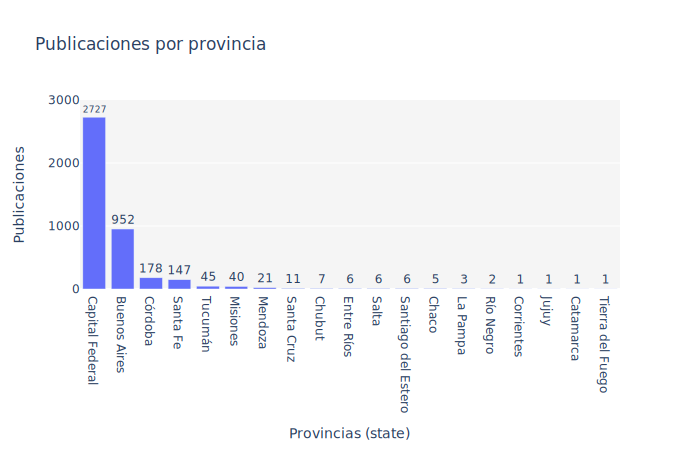

In [508]:
loc_2plot = (df.groupby('state_name')['domain_id'].agg(['count'])).sort_values(by = 'count', ascending=False)
xx = np.array(loc_2plot.index)
yy = np.array(loc_2plot)

fig = px.bar(x= xx, y=yy, title = 'Publicaciones por provincia')
fig.update_layout(
    xaxis_title="Provincias (state)",
    yaxis_title="Publicaciones",
    plot_bgcolor= 'whitesmoke',autosize=True)
fig.update_traces(texttemplate=list(loc_2plot['count']), textposition='outside')
fig.update_yaxes(range=[0.0,3000.0], constrain="domain")
fig.show('svg')

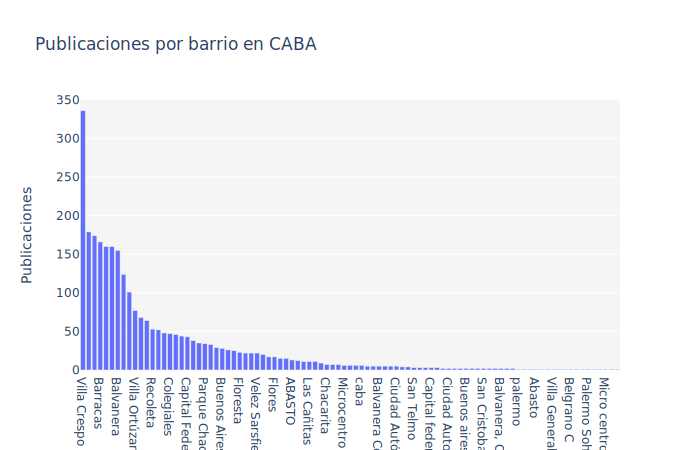

In [509]:
caba_2plot = (df[df['state_name']=='Capital Federal'].groupby('city_name')['domain_id'].agg(['count'])).\
    sort_values(by = 'count', ascending=False)
xx = np.array(caba_2plot.index)
yy = np.array(caba_2plot)

fig = px.bar(x= xx, y=yy, title = 'Publicaciones por barrio en CABA')
fig.update_layout(
    xaxis_title='',
    yaxis_title='Publicaciones',
    plot_bgcolor= 'whitesmoke',autosize=True)
fig.update_yaxes(range=[0.0,350.0], constrain="domain")
fig.show('svg')

In [510]:
# top10 barrios con mas publicaciones
caba_2plot.iloc[range(0,10),:]

,count
city_name,
Villa Crespo,336
Belgrano,179
Monserrat,174
Barracas,166
San Nicolás,160
Parque Patricios,160
Balvanera,155
Villa Urquiza,124
Palermo,101


Otro atributo intersante para rescatar es el envio o *shipping*, en algunas oportunidades tomamos en cuenta las condiciones de envio para realizar una compra, aunque por el precio medio de la mayoria de estos, es probable que la mayoria sea gratuito (free)

In [511]:
d3 = extrac_new_DF_from_colum(df, 'shipping', 1)
d3

,free_shipping,mode,tags,logistic_type,store_pick_up
0,True,me2,"[mandatory_free_shipping, self_service_in]",cross_docking,False
1,True,me2,"[fulfillment, mandatory_free_shipping]",fulfillment,False
2,True,me2,"[fulfillment, mandatory_free_shipping]",fulfillment,False
3,True,me2,"[self_service_in, mandatory_free_shipping]",cross_docking,False
4,True,me2,"[fulfillment, mandatory_free_shipping]",fulfillment,False
...,...,...,...,...,...
4155,True,me2,"[self_service_in, mandatory_free_shipping]",cross_docking,False
4156,True,me2,[mandatory_free_shipping],xd_drop_off,False
4157,True,me2,"[self_service_in, mandatory_free_shipping]",drop_off,False
4158,True,me2,"[self_service_in, mandatory_free_shipping]",cross_docking,False


En este caso no expandi directamente el data set ya que existe otra columna con el nombre *tags*.

In [512]:
d3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   free_shipping  4160 non-null   bool  
 1   mode           4160 non-null   object
 2   tags           4160 non-null   object
 3   logistic_type  4160 non-null   object
 4   store_pick_up  4160 non-null   bool  
dtypes: bool(2), object(3)
memory usage: 105.8+ KB


In [513]:
d3['mode'].value_counts()

me2              3794
not_specified     210
custom            143
me1                13
Name: mode, dtype: int64

In [514]:
d3['logistic_type'].value_counts()

cross_docking    2040
drop_off          893
xd_drop_off       511
fulfillment       350
not_specified     210
custom            143
default            13
Name: logistic_type, dtype: int64

In [515]:
d3['store_pick_up'].value_counts()

False    3998
True      162
Name: store_pick_up, dtype: int64

De todos estos datos posiblemente el que mas vea un usuario que va a realizar una compra sea si el envio es gratuito o no, no necesariamente todas estas condiciones, pero dejare esto para una instancia de modelado.

<a href="#top">Back to Index</a>
<a id="3"></a>
### 3) Conclusion de Parte I
<a id="3.1"></a>
#### 3.1) Preparacion del data set final

Preparo el data set final que empleare en la PARTE II instancia de modelado, donde se seguira tratando el data set final obtenido en esta instancia pero enfocando para su uso en un algoritmo, por lo tanto pasara por las intancias de limpieza, feature seleccition y feature engineering.

In [520]:
# concatenamos los datasets obtenidos hasta el momento
df_part1 = pd.concat([df, df2, d3], axis = 1)
df_part1.shape

(4160, 63)

In [521]:
df_part1.to_excel('./data/data_part1.xlsx', index= False)
df_part1.to_csv('./data/data_part1.csv', index= False)

<a id="3.2"></a>
#### 3.2) Comentarios finales

Como se pudo observar en el analisis exploratorio realizado, se pudo ver los siguiente:
* Las busquedas pueden ser mas o menos precisas en funcion del tag de la busqueda, por ejemplo *tv 4k* trajo aparejada una mayor cantidad de categorias (distintos *domain_id*), no paso asi con las demas
* El descuento promedio en las publicaciones es del 15%, y hay un 17% de productos de descuentos en la parte electronica (de esta muestra).
* Las notebooks son el producto con mayor cantidad de productos en descuento, sin embargo las tablets son las que ofrecen mayor descuento promedio en su precio de publicado


Para más detalles visitar el repositorio <a href = 'https://github.com/Mattzvl/EDA_API_ML'>EDA_API_MELI</a> que contiene este archivo y la parte II

In [473]:
#pip freeze > requirements.txt